In [16]:
import glob
import cv2
import math 
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import json
import datetime
import matplotlib.image as mpimg
import random
import time


%matplotlib inline
import pandas as pd
import numpy as np
np.random.bit_generator = np.random._bit_generator

from tensorflow.keras.preprocessing import image
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, Flatten,MaxPooling2D, concatenate, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model,load_model
#from keras_segmentation.models.model_utils import get_segmentation_mode
from tensorflow.keras.metrics import MeanIoU

# from tensorflow.keras.utils import np_utils
from skimage.transform import resize
from datetime import datetime
from mpl_toolkits.mplot3d import Axes3D
from imgaug import augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage

In [17]:
color_label_val = '../data/mapillary-vistas-dataset_public_v1.1/validation/labels/'
color_label_train = '../data/mapillary-vistas-dataset_public_v1.1/training/labels/'

image_val = '../data/mapillary-vistas-dataset_public_v1.1/validation/images/'
image_train = '../data/mapillary-vistas-dataset_public_v1.1/training/images/'



IMG_HEIGHT = 480 #640x480, 320x240, 160x120
IMG_WIDTH = 640
NUM_SEG = 13
#_drivable_id.png
#_drivable_color.png

In [18]:
from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.gpu_options.per_process_gpu_memory_fraction = 0.8
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)

In [19]:
from tensorflow.python.client import device_lib

tf.test.gpu_device_name()


'/device:GPU:0'

In [20]:
#Create dictonary for id to new id, add color for each id later. 

color_id_map = {
       0: [3], 
       1: [3], 
       2: [8],
       3: [2],
       4: [2],
       5: [3],
       6: [11],
       7: [8], 
       8: [7], 
       9: [8],
       10: [7], 
       11: [8], 
       12: [0], 
       13: [7],
       14: [7], 
       15: [8],
       16: [0], 
       17: [1],
       18: [0], 
       19: [4],
       20: [4],
       21: [10],
       22: [10],
       23: [6],
       24: [6],
       25: [0],
       26: [0],
       27: [0], 
       28: [0], 
       29: [0], 
       30: [9],
       31: [0], 
       32: [3],
       33: [3],
       34: [3],
       35: [3],
       36: [3],
       37: [3],
       38: [3],
       39: [3],
       40: [3],
       41: [7],
       42: [3],
       43: [7],
       44: [5],
       45: [5],
       46: [12],
       47: [5],
       48: [12],
       49: [12],
       50: [12],
       51: [3],
       52: [3],
       53: [3],
       54: [10],
       55: [10],
       56: [10],
       57: [10],
       58: [0], 
       59: [10],
       60: [10],
       61: [10],
       62: [10],
       63: [0],
       64: [0],
       65: [0],        
    }

In [21]:
def random_augment(img, mask):
    """
    #if np.random.rand() < 0.5:
    #    img, mask = img_random_flip(img, mask)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    seq = iaa.Sequential([
        iaa.Fliplr(0.5),
        #iaa.Multiply((0.90, 1.10)),
        #iaa.Dropout([0.0, 0.2]),
        #iaa.Add((-40, 40)),
        #iaa.Superpixels(p_replace=0.5, n_segments=64),
        #iaa.Affine(scale=(1, 1.3),translate_percent=(-0.1, 0.1),rotate=(-15, 15),shear=(-2, 2))
        
    ])
    
    mask = cv2.normalize(mask, None, 0, 1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC3)    
    #mask = np.uint8(np.where(mask > 0, 1, 0))
    
    #height, width, _ = img.shape
    segmap = SegmentationMapsOnImage(mask, shape=img.shape, nb_classes=NUM_SEG)
    
    img_aug, mask = seq(image=img, segmentation_map=segmap)
    mask = mask.draw([IMG_HEIGHT, IMG_WIDTH, NUM_SEG]) #, colors=[(0, 0, 0), (255, 0, 0), (0, 0, 255)]
    c1, _, _ = cv2.split(mask[0])
    c2, _, _ = cv2.split(mask[2])
    
    rb_mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 2), dtype=np.uint8)
    rb_mask[..., 0] = c1
    rb_mask[..., 1] = c2
    """
    return img, mask

def apply_color_map(image_array, labels):
    color_array = np.zeros((image_array.shape[0], image_array.shape[1], 3), dtype=np.uint8)
    print(image_array.shape)
    print(color_array.shape)
    for label_id, label in enumerate(labels):
        # set all pixels with the current label to the color of the current label
        #print(label["color"])
        image_array[:,:,:] == label["color"]
        color_array[image_array == label_id] = label["color"]
        #print(color_array[image_array == label_id])

    return color_array

def get_img_name(path):
    names = glob.glob(f"{path}*")
    names.sort()
    return names

def img_process(img):
    img = cv2.resize(img, (IMG_WIDTH,IMG_HEIGHT)) #640x480, 320x240
    return img

def show_seg_on_img(img, mask, alpha=0.5):
    #img = img.astype(np.float64)*255
    #img = cv2.normalize(img, None, 0, 255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC3)
    #mask = mask.astype(np.float64)*255
    #mask = cv2.normalize(mask, None, 0, 255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC3)
    
    img_mask = cv2.addWeighted(mask, alpha, img, 0.5, 0)
    return img_mask 

def compare_img(img1, img2, title1 = 'Image 1', title2 = 'Image 2'):
    #img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    #img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    
    fig = plt.figure(figsize=(16, 12))
    a = fig.add_subplot(1,2,1)
    imgplot = plt.imshow(img1)
    a.set_title(title1)

    a = fig.add_subplot(1, 2, 2)
    imgplot = plt.imshow(img2)
    a.set_title(title2)

In [22]:
    # read in config file
    with open('../data/mapillary-vistas-dataset_public_v1.1/config.json') as config_file:
        config = json.load(config_file)
    # in this example we are only interested in the labels
    labels = config['labels']

    # print labels
    print("There are {} labels in the config file".format(len(labels)))
    for label_id, label in enumerate(labels):
        color_id_map[label_id].append(label["color"])
        print("{:>30} ({:2d}): {:<40} has instances: {}".format(label["readable"], label_id, label["name"], label["instances"]))
        

There are 66 labels in the config file
                          Bird ( 0): animal--bird                             has instances: True
                 Ground Animal ( 1): animal--ground-animal                    has instances: True
                          Curb ( 2): construction--barrier--curb              has instances: False
                         Fence ( 3): construction--barrier--fence             has instances: False
                    Guard Rail ( 4): construction--barrier--guard-rail        has instances: False
                       Barrier ( 5): construction--barrier--other-barrier     has instances: False
                          Wall ( 6): construction--barrier--wall              has instances: False
                     Bike Lane ( 7): construction--flat--bike-lane            has instances: False
             Crosswalk - Plain ( 8): construction--flat--crosswalk-plain      has instances: True
                      Curb Cut ( 9): construction--flat--curb-cut        

In [23]:
print(color_id_map[0])

[3, [165, 42, 42]]


In [24]:
color_label_val_list = get_img_name(color_label_val)
color_label_train_list = get_img_name(color_label_train)

img_val_list = get_img_name(image_val)
img_train_list = get_img_name(image_train)



print(f'Color label val size: {len(color_label_val_list)}')
print(f'Color  label train size: {len(color_label_train_list)}')
print()
print(f'Img val size size: {len(img_val_list)}')
print(f'Img train size size: {len(img_train_list)}')
print()
print(f'eksmaple path color label: {color_label_train_list[0]}')
print(f'eksmaple path img label: {img_train_list[0]}')

Color label val size: 2000
Color  label train size: 18000

Img val size size: 2000
Img train size size: 18000

eksmaple path color label: ../data/mapillary-vistas-dataset_public_v1.1/training/labels/--NSVcUgfVhFd6uzkqHOOg.png
eksmaple path img label: ../data/mapillary-vistas-dataset_public_v1.1/training/images/--NSVcUgfVhFd6uzkqHOOg.jpg


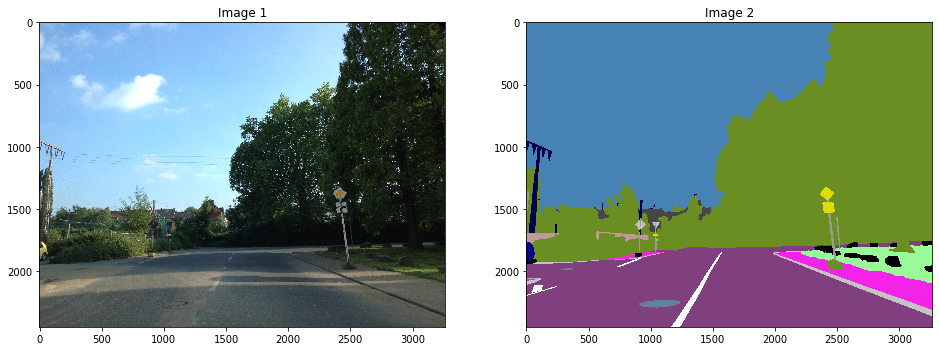

In [25]:
img = cv2.cvtColor(cv2.imread(img_train_list[0]), cv2.COLOR_BGR2RGB)
mask = cv2.cvtColor(cv2.imread(color_label_train_list[0]), cv2.COLOR_BGR2RGB)

compare_img(img, mask)

(2448, 3264, 3)


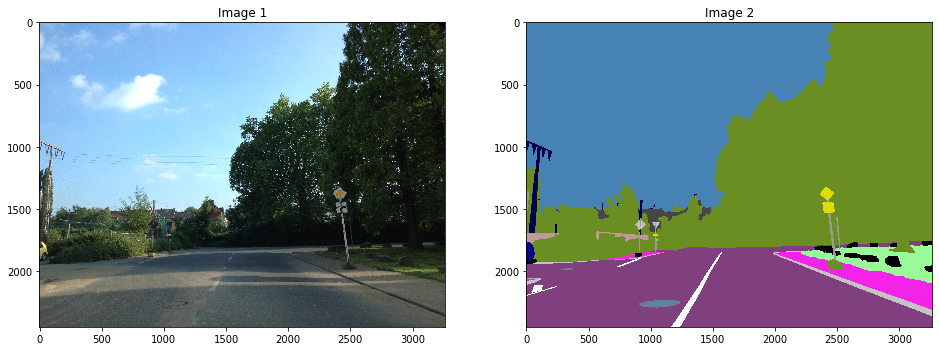

In [26]:
img, mask = random_augment(img, mask)
compare_img(img, mask)
print(mask.shape)

In [27]:
'''
from PIL import Image

# convert labeled data to numpy arrays for better handling
base_image = Image.open(img_val_list[0])
label_image= Image.open(color_label_val_list[0])
instance_image = Image.open('mapillary-vistas-dataset_public_v1.1/training/instances/_0A_W6lEi-7W0RvVEiKkyQ.png')
panoptic_image = Image.open('mapillary-vistas-dataset_public_v1.1/training/panoptic/_0R1piHytmNxzCyp5YjF8g.png')

label_array = np.array(label_image)
instance_array = np.array(instance_image, dtype=np.uint16)

# now we split the instance_array into labels and instance ids
instance_label_array = np.array(instance_array / 256, dtype=np.uint8)
instance_ids_array = np.array(instance_array % 256, dtype=np.uint8)


# for visualization, we apply the colors stored in the config
colored_label_array = apply_color_map(label_array, labels)
colored_instance_label_array = apply_color_map(instance_label_array, labels)


# plot the result
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(20,15))

ax[0][0].imshow(base_image)
ax[0][0].get_xaxis().set_visible(False)
ax[0][0].get_yaxis().set_visible(False)
ax[0][0].set_title("Base image")
ax[0][1].imshow(colored_label_array)
ax[0][1].get_xaxis().set_visible(False)
ax[0][1].get_yaxis().set_visible(False)
ax[0][1].set_title("Labels")
ax[1][0].imshow(instance_ids_array)
ax[1][0].get_xaxis().set_visible(False)
ax[1][0].get_yaxis().set_visible(False)
ax[1][0].set_title("Instance IDs")
ax[1][1].imshow(colored_instance_label_array)
ax[1][1].get_xaxis().set_visible(False)
ax[1][1].get_yaxis().set_visible(False)
ax[1][1].set_title("Labels from instance file (identical to labels above)")
ax[2][0].imshow(panoptic_image)
ax[2][0].get_xaxis().set_visible(False)
ax[2][0].get_yaxis().set_visible(False)
ax[2][0].set_title("Labels from panoptic")
ax[2][1].axis('off')

fig.tight_layout()
#fig.plot()
#fig.savefig('MVD_plot.png')
'''

'\nfrom PIL import Image\n\n# convert labeled data to numpy arrays for better handling\nbase_image = Image.open(img_val_list[0])\nlabel_image= Image.open(color_label_val_list[0])\ninstance_image = Image.open(\'mapillary-vistas-dataset_public_v1.1/training/instances/_0A_W6lEi-7W0RvVEiKkyQ.png\')\npanoptic_image = Image.open(\'mapillary-vistas-dataset_public_v1.1/training/panoptic/_0R1piHytmNxzCyp5YjF8g.png\')\n\nlabel_array = np.array(label_image)\ninstance_array = np.array(instance_image, dtype=np.uint16)\n\n# now we split the instance_array into labels and instance ids\ninstance_label_array = np.array(instance_array / 256, dtype=np.uint8)\ninstance_ids_array = np.array(instance_array % 256, dtype=np.uint8)\n\n\n# for visualization, we apply the colors stored in the config\ncolored_label_array = apply_color_map(label_array, labels)\ncolored_instance_label_array = apply_color_map(instance_label_array, labels)\n\n\n# plot the result\nfig, ax = plt.subplots(nrows=3, ncols=2, figsize=(20,1

In [28]:
def labels_to_maskes(img_label, color_id_map, num_channels):
    num_objects = len(color_id_map.keys())
    
    height = img_label.shape[0]
    width = img_label.shape[1]
    
    channels_big = np.zeros((height, width , num_objects), dtype=np.uint8)
    
    
    for key, value in color_id_map.items():
        mask = (img_label == value[1]).all(-1)
        channels_big[... ,key] = mask 
    
    channels_reduced = np.zeros((height, width, num_channels), dtype=np.uint8)

    for key, value in color_id_map.items():
        channels_reduced[:,:, value[0]] = np.logical_or(channels_reduced[:,:, value[0]], channels_big[:,:, key])
    

    return channels_reduced 
    

masks = labels_to_maskes(mask, color_id_map, NUM_SEG)



In [29]:
print(f'mask shape: {masks.shape}')

mask shape: (2448, 3264, 13)


In [30]:
def maskes_to_labels(maskes):
    
    maskes = (maskes > 0.4).astype(np.uint8)
    labels = np.zeros((maskes.shape[0], maskes.shape[1], 3), dtype=np.uint8)
    
    classes_cc = { #cc = carla cityScape
        0: [0, 0, 0],        # None
        1: [70, 70, 70],     # Buildings
        2: [190, 153, 153],  # Fences
        3: [72, 0, 90],      # Other
        4: [220, 20, 60],    # Pedestrians
        5: [153, 153, 153],  # Poles
        6: [157, 234, 50],   # RoadLines
        7: [128, 64, 128],   # Roads
        8: [244, 35, 232],   # Sidewalks
        9: [107, 142, 35],   # Vegetation
        10: [0, 0, 255],     # Vehicles
        11: [102, 102, 156], # Walls
        12: [220, 220, 0]    # TrafficSigns
    }
    
    for key, value in classes_cc.items():
        mask = maskes[..., key]
        new_values =  mask[..., None] * value
        
        labels = labels + new_values
    
    return labels 
    
labels = maskes_to_labels(masks)    
        

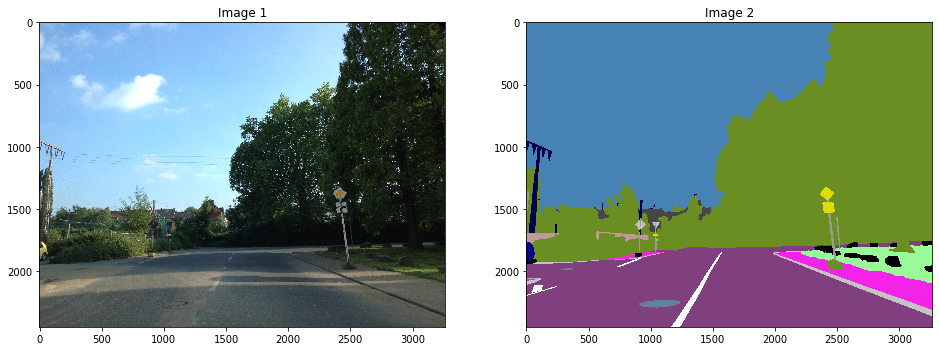

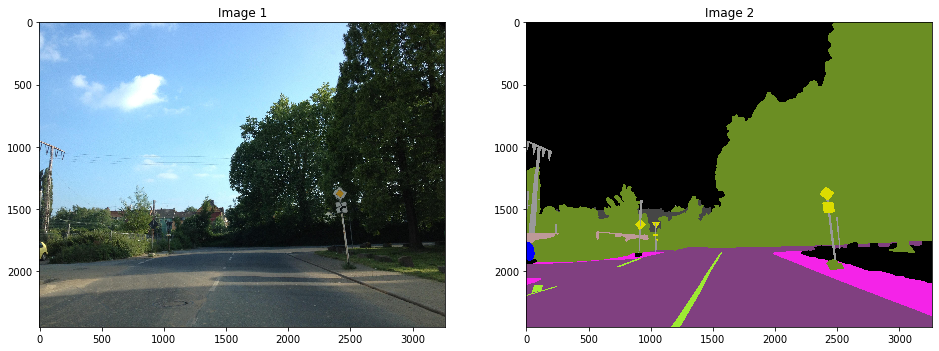

In [31]:
compare_img(img, mask)
compare_img(img, labels)


In [32]:
def batch_generator(image_paths, label_path ,batch_size, color_labels, index=0, training=True):
    
    
    index = index
    label_path_list = label_path
    image_paths_list = image_paths
    
    
    while True:
        
        images = []
        #drivable_area = np.array([])#np.ndarray(shape=(IMG_HEIGHT, IMG_WIDTH, NUM_SEG))
        maskes = []
        data_size = len(label_path_list)
        
        for i in range(batch_size):
            #image_id = images_ids.sample()
            
            index += 1
            if index >= data_size:
                index = 0
                
            img_url = image_paths_list[index]
            label_url = label_path_list[index]
            
            img = cv2.imread(img_url)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            mask = cv2.imread(label_url)
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
            
            img = img_process(img)
            mask = img_process(mask)
            
            
            if training:
                img, mask = random_augment(img, mask)
                
            mask = labels_to_maskes(mask, color_labels, NUM_SEG)
            
            images.append(img)
            maskes.append(mask) #.tolist()
            #drivable_area = np.append(drivable_area, rb_img, axis=0)

        yield (np.asarray(images), np.asarray(maskes)) # drivable_area

In [33]:

x_train_gen, y_train_gen = next(batch_generator(img_train_list, color_label_train_list, 1, color_id_map))

In [34]:
y_train_maskes = y_train_gen[0]
print(f'mask shape: {y_train_maskes.shape}')

#compare_img(x_train_gen[0]*255, *255)

mask shape: (480, 640, 13)


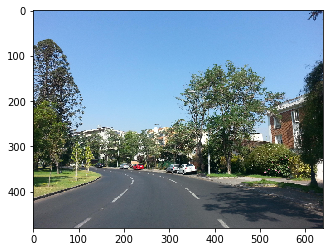

In [35]:
plt.imshow(x_train_gen[0])

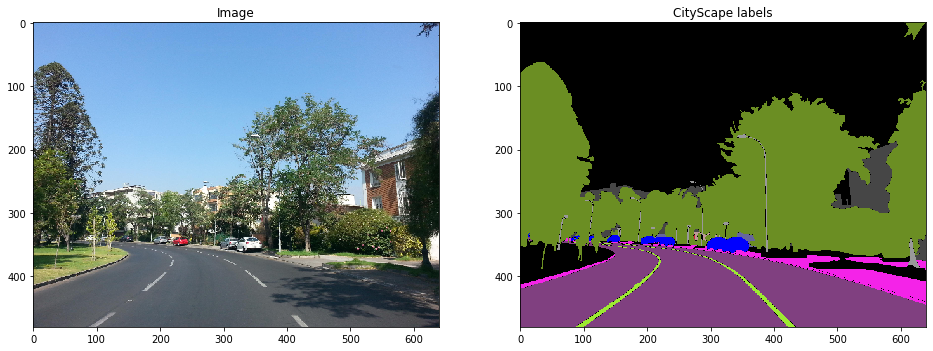

In [36]:
y_train_label = maskes_to_labels(y_train_maskes)
compare_img(x_train_gen[0], y_train_label, 'Image', 'CityScape labels')


In [37]:
def create_setup(labels_train, labels_val, dataset, min_data, max_data, arc):
    data_amount = np.random.randint(low=min_data, high=max_data)
    ids_train = []
    ids_val = []
    architecture = arc
    created = round(time.time())
    
    training_time = 0
    
    model_info = {}
    name = f'{architecture}_{created}.h5'
    
    model_info[name] = {
        'created': created, 
        'training_time': 0,
        'data_amount': 0,
        'architecture': arc,
        'dataset': dataset,
        'notes': 'no modification'
    }
            
    
    return data_train, data_val, model_info, name
    
    

def save_model(model, name, model_info):
    model.save(f'seg_models/{name}.h5')

    json_file_name = 'model_info.json'

    with open(json_file_name, 'r') as file_reader:
        model_data = json.load(file_reader)

    model_data.update(model_info)
    file_reader.close()

    with open(json_file_name, "w") as file_write:
    # write json data into file
        json.dump(model_data, file_write)
    file_write.close() 
    

In [53]:
activation = 'relu'
dropout = 0.15 # 0.2
mc = True #if droput shoud ocure after training

img_input = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))#640x480, 320x240

conv1 = Conv2D(64, (3, 3), activation=activation, padding='same')(img_input)
conv1 = Dropout(dropout)(conv1, training=mc)
conv1 = Conv2D(64, (3, 3), activation=activation, padding='same')(conv1)
pool1 = MaxPooling2D((2, 2))(conv1)

conv2 = Conv2D(128, (3, 3), activation=activation, padding='same')(pool1)
conv2 = Dropout(dropout)(conv2, training=mc)
conv2 = Conv2D(128, (3, 3), activation=activation, padding='same')(conv2)
pool2 = MaxPooling2D((2, 2))(conv2)

conv3 = Conv2D(256, (3, 3), activation=activation, padding='same')(pool2)
conv3 = Dropout(dropout)(conv3, training=mc)
conv3 = Conv2D(256, (3, 3), activation=activation, padding='same')(conv3)
pool3 = MaxPooling2D((2, 2))(conv3)

conv4 = Conv2D(512, (3, 3), activation=activation, padding='same')(pool3)
conv4 = Dropout(dropout)(conv4, training=mc)
conv4 = Conv2D(512, (3, 3), activation=activation, padding='same')(conv4)

up1 = concatenate([UpSampling2D((2, 2))(conv4), conv3], axis=-1)
conv5 = Conv2D(256, (3, 3), activation=activation, padding='same')(up1)
conv5 = Dropout(dropout)(conv5, training=mc)
conv5 = Conv2D(256, (3, 3), activation=activation, padding='same')(conv5)

up2 = concatenate([UpSampling2D((2, 2))(conv5), conv2], axis=-1)
conv6 = Conv2D(128, (3, 3), activation=activation, padding='same')(up2)
conv6 = Dropout(dropout)(conv6, training=mc)
conv6 = Conv2D(128, (3, 3), activation=activation, padding='same')(conv6)


up3 = concatenate([UpSampling2D((2, 2))(conv6), conv1], axis=-1)
conv7 = Conv2D(64, (3, 3), activation=activation, padding='same')(up3)
conv7 = Dropout(dropout)(conv7, training=mc)
conv7 = Conv2D(32, (3, 3), activation=activation, padding='same')(conv7)

out = Conv2D(NUM_SEG, (1,1), padding='same', activation='sigmoid')(conv7)

model = Model(inputs=[img_input], outputs=[out])

optimizer = Adam(lr=1e-3) #10 epocher er bra på -3
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[MeanIoU(num_classes=NUM_SEG)])#'accuracy'

In [54]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 480, 640, 3) 0                                            
__________________________________________________________________________________________________
conv2d_45 (Conv2D)              (None, 480, 640, 64) 1792        input_4[0][0]                    
__________________________________________________________________________________________________
dropout_21 (Dropout)            (None, 480, 640, 64) 0           conv2d_45[0][0]                  
__________________________________________________________________________________________________
conv2d_46 (Conv2D)              (None, 480, 640, 64) 36928       dropout_21[0][0]                 
____________________________________________________________________________________________

In [55]:

amount_data = len(img_train_list)
batch_size =  32 
stp = ((amount_data) // batch_size)
history = model.fit(batch_generator(img_train_list, color_label_train_list, 1, color_id_map), 
                                steps_per_epoch= stp, #stp
                                epochs=10, #10 hvirker mer en nokk
                                validation_data=batch_generator(img_val_list, color_label_val_list, 1, color_id_map, training= False), #100
                                validation_steps=stp//5, # 200
                                verbose=1,
                                #callbacks=[cp_callback],
                                use_multiprocessing=True)

Epoch 1/10
562/562 [==============================] - 403s 718ms/step - loss: 0.2958 - mean_io_u_3: 0.4620 - val_loss: 0.1803 - val_mean_io_u_3: 0.4618
Epoch 2/10
562/562 [==============================] - 381s 677ms/step - loss: 0.1654 - mean_io_u_3: 0.4618 - val_loss: 0.1666 - val_mean_io_u_3: 0.4618
Epoch 3/10
562/562 [==============================] - 375s 667ms/step - loss: 0.1672 - mean_io_u_3: 0.4618 - val_loss: 0.1582 - val_mean_io_u_3: 0.4618
Epoch 4/10
562/562 [==============================] - 375s 667ms/step - loss: 0.1477 - mean_io_u_3: 0.4618 - val_loss: 0.1506 - val_mean_io_u_3: 0.4619
Epoch 5/10
562/562 [==============================] - 376s 670ms/step - loss: 0.1432 - mean_io_u_3: 0.4619 - val_loss: 0.1425 - val_mean_io_u_3: 0.4645
Epoch 6/10
562/562 [==============================] - 376s 669ms/step - loss: 0.1403 - mean_io_u_3: 0.4618 - val_loss: 0.1513 - val_mean_io_u_3: 0.4618
Epoch 7/10
562/562 [==============================] - 373s 664ms/step - loss: 0.1376 - m

Text(0.5, 0, 'Epoch')

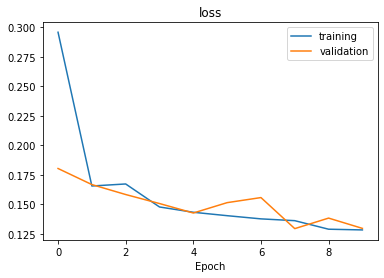

In [56]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('loss')
plt.xlabel('Epoch')

(480, 640, 13)


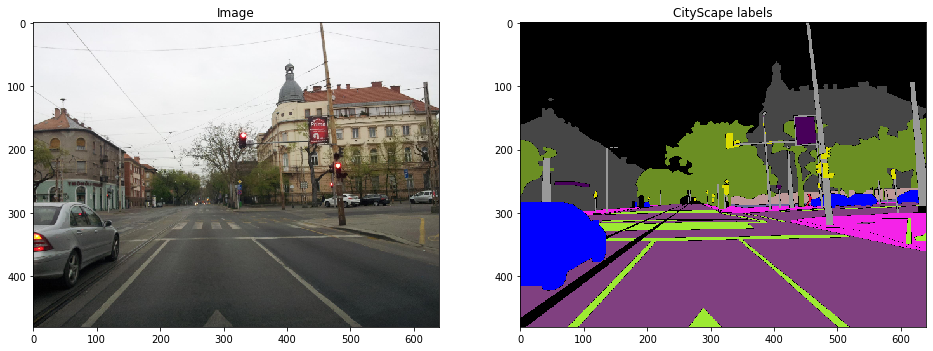

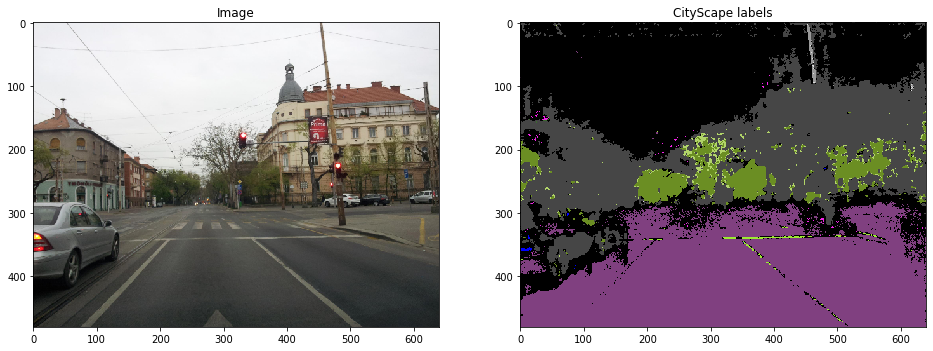

In [57]:
x_train_val, y_train_val = next(batch_generator(img_val_list, color_label_val_list, 1, color_id_map, training= False))
img_predicted = model.predict(x_train_val)[0]
target = maskes_to_labels(y_train_val[0]).astype(np.uint8)

print(img_predicted.shape)

y_train_label = maskes_to_labels(img_predicted).astype(np.uint8)
compare_img(x_train_val[0], target, 'Image', 'CityScape labels')
compare_img(x_train_val[0], y_train_label, 'Image', 'CityScape labels')

In [58]:
print(f'image: {x_train_val[0].dtype}')
print(f'predictions: {y_train_label.dtype}')

image: uint8
predictions: uint8


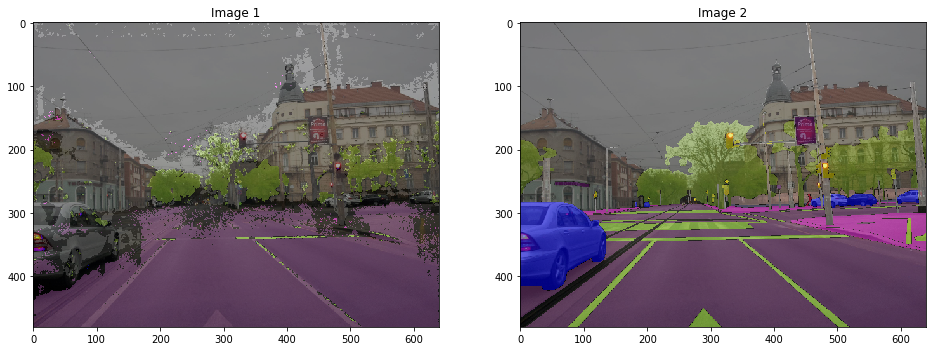

In [59]:


img_mask = cv2.addWeighted(y_train_label, 0.5, x_train_val[0], 0.5, 0)
img_target = cv2.addWeighted(target, 0.5, x_train_val[0], 0.5, 0)

compare_img(img_mask, img_target)

In [60]:
model.save(f'u-net_mc_v1.h5')

In [61]:
model = load_model('../seg_models/u-net_v1.h5')